In [1]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import silhouette_samples, silhouette_score
from statsmodels.tools.tools import add_constant
import statsmodels.formula.api as smf
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import sklearn.cluster as sklc
import sklearn.metrics as sklm
import statsmodels.api as sm
import scipy.stats as sps
import seaborn as sns
import pandas as pd
import numpy as np

# we are selecing columns that are needed only.
cols = ['id', 'neighbourhood_cleansed', 'price', 'last_review','host_response_rate', 
        'host_acceptance_rate', 'review_scores_rating', 
        'review_scores_value', 'review_scores_location',
        'review_scores_communication', 'review_scores_cleanliness', 
        'accommodates', 'beds', 'bedrooms', 'review_scores_checkin']

cw_data = pd.read_csv('listings.csv', low_memory=True, usecols=cols)

cw_data = cw_data.dropna()

# yearly income = monthly occupancy rate * price * 12
cw_data['price'] = cw_data.price.str.replace('$', '').str.replace(',', '').astype(float)

# change the data type of last_review column to actual datetime object.
cw_data['last_review'] = pd.to_datetime(cw_data['last_review'])

# remove the symbol which may cause error for calculation.
cw_data['host_response_rate'] = cw_data.host_response_rate.str.replace('%', '').astype(float) / 100
cw_data['host_acceptance_rate'] = cw_data.host_acceptance_rate.str.replace('%', '').astype(float) / 100

recent_cw_data = cw_data[cw_data.last_review > '2021-06-01']
recent_cw_data = recent_cw_data.dropna()
recent_cw_data = recent_cw_data[['price', 'neighbourhood_cleansed', 'host_response_rate', 'host_acceptance_rate', 'review_scores_rating',
                                'review_scores_value', 'review_scores_location', 'review_scores_communication', 'review_scores_cleanliness',
                                'accommodates', 'beds', 'bedrooms', 'review_scores_checkin']]

# similar to what we did above, we are now calculating the mean and median of yearly income of different locations of London.
recent_cw_data_2 = recent_cw_data.set_index('neighbourhood_cleansed').groupby('neighbourhood_cleansed').agg('mean').reset_index()

/tmp/ipykernel_171/1791942995.py:27: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  cw_data['price'] = cw_data.price.str.replace('$', '').str.replace(',', '').astype(float)


In [23]:
X = recent_cw_data_2 ['review_scores_location']
Y = recent_cw_data_2 ['price']

plt.xlabel('review_scores_location')
plt.ylabel('price')

a = plt.plot(X,Y,'.', label = 'original data')

#plt.xlim(0,200)
#plt.ylim(4,10)

slope, intercept, r_value, p_value, std_err = sps.linregress(X, Y) 

b = plt.plot(X, X*slope + intercept, 'r', label='fitted line')

plt.legend()
plt.show()

print("y =", round(slope, 3), "x +", round(intercept, 3))
print("Rsq = ", r_value**2)
print("p-value = ", p_value)

corr, corr_p_val = sps.pearsonr(X, Y)
print("Correlation between X and Y:", round(corr, 3))

y = 367.395 x + -1630.302
Rsq =  0.47597706133924733
p-value =  8.920597234046446e-06
Correlation between X and Y: 0.69


In [18]:
multi_regression_model = smf.ols(formula = 'price ~ review_scores_location + accommodates + review_scores_checkin', data = recent_cw_data_2).fit()

# And this gives a big summary of the results:
print(multi_regression_model.summary())

# Pick out some values of interest and print the regression equation:
beta_0, beta_1, beta_2, beta_3 = multi_regression_model.params
rsq = multi_regression_model.rsquared
pval_0, pval_1, pval_2, pval_3 = multi_regression_model.pvalues

print("y =", round(beta_1,3), "x1 +", round(beta_2,3), "x2 +", round(beta_3,3), "x3 +", round(beta_0,3))
print("R^2 =", rsq)
print("p-value_1 =", round(pval_1,3))
print("p-value_2 =", round(pval_2,3))
print("p-value_3 =", round(pval_3,3))

# Produce regression plots
fig = plt.figure(figsize = (10,8))
fig = sm.graphics.plot_regress_exog(multi_regression_model, 'review_scores_location', fig = fig)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.811
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     41.60
Date:                Thu, 13 Jan 2022   Prob (F-statistic):           1.25e-10
Time:                        16:02:49   Log-Likelihood:                -141.24
No. Observations:                  33   AIC:                             290.5
Df Residuals:                      29   BIC:                             296.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                -20

Text(0.5, 1.0, 'Correlation Matrix')

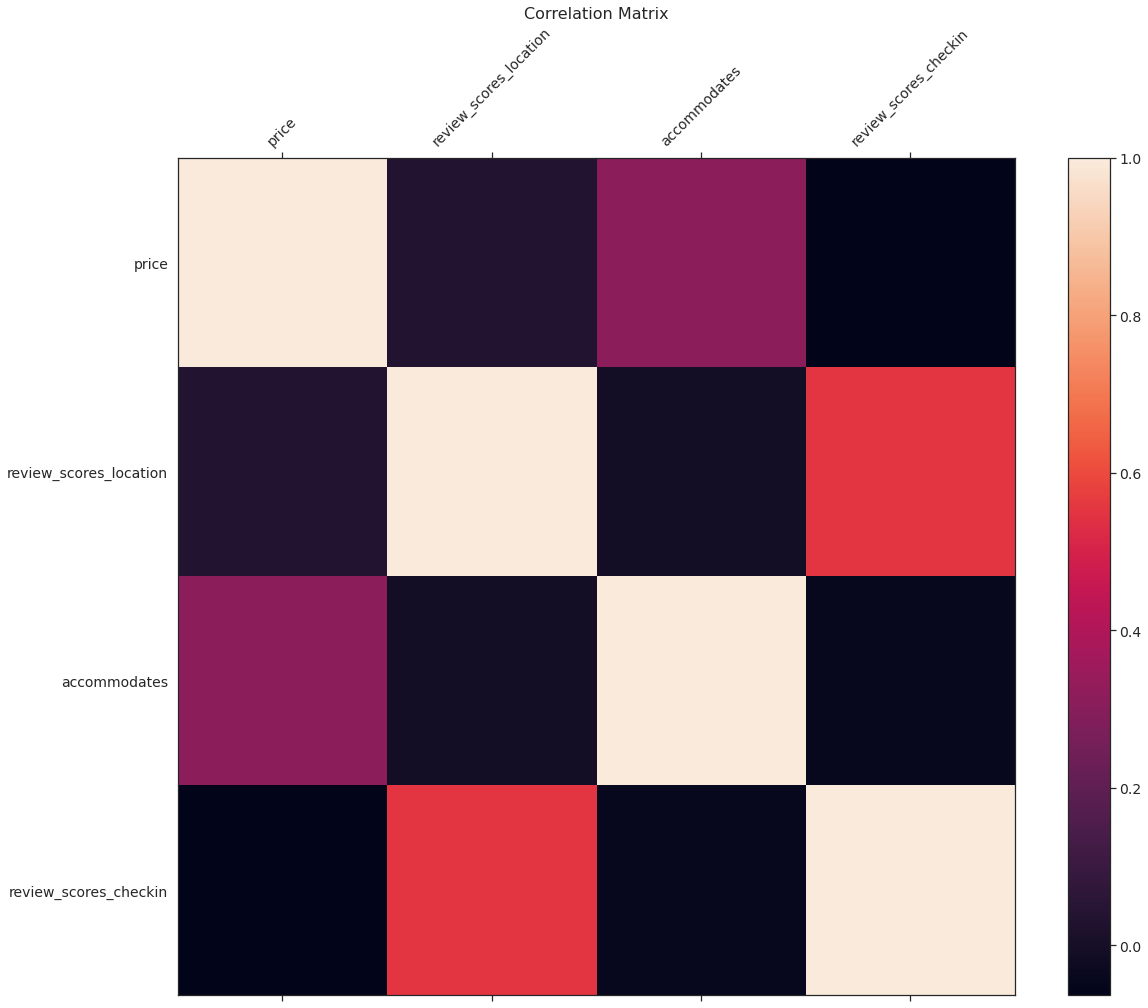

In [24]:
df = cw_data.loc[:,['price', 'review_scores_location', 'accommodates', 'review_scores_checkin']]
plt.rcParams["axes.grid"] = False
f = plt.figure(figsize = (19, 15))
plt.matshow(df.corr(), fignum = f.number)
plt.xticks(range(df.shape[1]), df.columns, fontsize = 14, rotation = 45)
plt.yticks(range(df.shape[1]), df.columns, fontsize = 14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize = 14)
plt.title('Correlation Matrix', fontsize = 16)

In [10]:
cw_data_sample = recent_cw_data_2.loc[:,['price', 'review_scores_location','accommodates','review_scores_cleanliness']]

def drop_column_using_vif_(df, thresh = 5):

    while True:
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name = "VIF", index = df_with_const.columns).to_frame()

        # drop the const
        vif_df = vif_df.drop('const')
        
        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df

cw_data_VIF = drop_column_using_vif_(cw_data_sample.drop('price', axis = 1))

cw_data_VIF

/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


review_scores_location  accommodates  review_scores_cleanliness
0                 4.535625      3.390625                   4.606406
1                 4.721472      3.263959                   4.588274
2                 4.605238      2.595238                   4.591667
3                 4.719912      2.924779                   4.730088
4                 4.732500      2.965909                   4.612045
5                 4.810347      3.308000                   4.563707
6                 4.832951      3.622951                   4.731311
7                 4.627584      2.921348                   4.587360
8                 4.706940      2.754098                   4.640546
9                 4.668119      2.396040                   4.725545
10                4.665067      3.262222                   4.622400
11                4.823253      3.061876                   4.716407
12                4.727847      3.572271                   4.637611
13                4.773148      3.361111                   4.727639
14                4.728197      2.803279                   4.709016
15                4.785962      3.442308                   4.672692
16                4.733942      3.519231                   4.601827
17                4.668140      3.296512                   4.655174
18                4.835229      3.067538                   4.666514
19                4.845401      3.435530                   4.558209
20                4.793977      3.250000                   4.690909
21                4.798023      3.197674                   4.684070
22                4.752178      3.099010                   4.715149
23                4.695317      2.960317                   4.657540
24                4.656878      3.351220                   4.607951
25                4.666211      3.210526                   4.660000
26                4.838431      3.522876                   4.710261
27                4.757349      3.070175                   4.618830
28                4.734857      2.228571                   4.625143
29                4.738314      3.166945                   4.550568
30                4.711013      3.234177                   4.611582
31                4.795199      3.238727                   4.658541
32                4.879138      3.673640                   4.596427

In [22]:
recent_cw_data_host = recent_cw_data_2[['price','host_response_rate','host_acceptance_rate']]
recent_cw_data_review_1 = recent_cw_data_2[['price','review_scores_rating','review_scores_value','review_scores_cleanliness']]
recent_cw_data_review_2 = recent_cw_data_2[['price','review_scores_location','review_scores_communication','review_scores_checkin']]
recent_cw_data_acc = recent_cw_data_2[['price','accommodates','beds','bedrooms']]

sns.set(style="white")
sns.pairplot(recent_cw_data_host, markers=".", height=3, diag_kind='kde')

sns.pairplot(recent_cw_data_review_1, markers=".", height=3, diag_kind='kde')

sns.pairplot(recent_cw_data_review_2, markers=".", height=3, diag_kind='kde')

sns.pairplot(recent_cw_data_acc, markers=".", height=3, diag_kind='kde')

# price vs. review_scores_location
# price vs. accommodates

KMeans(n_clusters=6, n_init=100)
[2 5 4 0 2 3 1 4 2 4 0 5 3 0 2 0 2 0 3 1 2 5 2 2 0 2 3 1 4 5 2 5 1]
[[  4.535625    76.203125     2.        ]
 [  4.72147208 113.11167513   5.        ]
 [  4.6052381   55.52380952   4.        ]
 [  4.7199115  106.51769912   0.        ]
 [  4.7325      86.15909091   2.        ]
 [  4.81034667 152.22933333   3.        ]
 [  4.83295082 201.42622951   1.        ]
 [  4.62758427  66.88202247   4.        ]
 [  4.70693989  77.17486339   2.        ]
 [  4.66811881  63.37623762   4.        ]
 [  4.66506667  98.09777778   0.        ]
 [  4.82325349 125.25149701   5.        ]
 [  4.72784661 143.71976401   3.        ]
 [  4.77314815  96.10648148   0.        ]
 [  4.72819672  84.67213115   2.        ]
 [  4.78596154 101.82692308   0.        ]
 [  4.73394231  83.58653846   2.        ]
 [  4.66813953  99.72093023   0.        ]
 [  4.83522876 134.82570806   3.        ]
 [  4.84540115 187.55730659   1.        ]
 [  4.79397727  86.57954545   2.        ]
 [  4.79802326 11

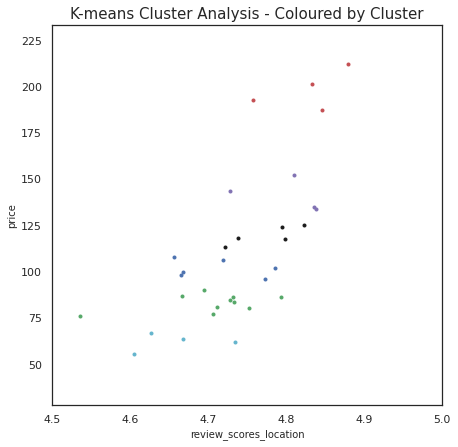

In [29]:
data = recent_cw_data_2[['review_scores_location', 'price']]

# This line sets the number of clusters you want to find:
num_clusters = 6

# Use the next line to set figure height and width.
figure_width, figure_height = 7,7

# These lines set the figure title and axis labels and the font sizes:
fig_title = 'K-means Cluster Analysis'
x_label = 'review_scores_location'
y_label = 'price'
title_fontsize = 15
label_fontsize = 10

# These lines set the limits of the x and y axes, so that all plots are on the same scale.
x_min, x_max = 4.5, 5
y_min, y_max = 0.5 * np.min(data.iloc[:,1]), 1.1 * np.max(data.iloc[:,1])

# This is a function that sets up each figure's x-limits and y-limits and axis labels.
def setup_figure():

    plt.xlim([x_min, x_max])
    plt.ylim([y_min, y_max])
    plt.xlabel(x_label, fontsize = label_fontsize)
    plt.ylabel(y_label, fontsize = label_fontsize)

#First extract the x and y values from the data:
x_values = data.iloc[:,0]
y_values = data.iloc[:,1]

# This line performs the k-means clustering:
kmeans_output = sklc.KMeans(n_clusters = num_clusters, n_init = 100).fit(data)

#And have a look as a sanity check
print(kmeans_output)

# This line creates a list giving the final cluster number of each point:
clustering_ids_kmeans = kmeans_output.labels_

# Which we can now look at
print(clustering_ids_kmeans)

# These lines add the cluster IDs to the original data and save the data with these added cluster IDs.
# Adding a new column line of data$cluster.
complete_data_with_clusters = np.hstack((data, np.array([clustering_ids_kmeans]).T))

# Have a look at the result:
print(complete_data_with_clusters)

# The loop below creates a separate data array for each cluster, and puts these arrays together in a list:
data_by_cluster = []

for i in range(num_clusters):

    this_data = []

    for row in complete_data_with_clusters:

        if row[-1] == i:
            this_data.append(row)

    this_data = np.array(this_data)

    data_by_cluster.append(this_data)

data_by_cluster

# This is a list of colours to differentiate each cluster.
color_list = ['b','r','g','m','c','k','y']

# These lines create a plot with all the data points, coloured by cluster.
plt.figure(num_clusters + 1, figsize = (figure_width, figure_height))
setup_figure()
plt.title(fig_title + ' - Coloured by Cluster',fontsize = title_fontsize)

for i in range(num_clusters):

    x_values = data_by_cluster[i][:,0]
    y_values = data_by_cluster[i][:,1]
    plt.plot(x_values, y_values, color_list[i % num_clusters] + '.')

# These lines calculate the silhouette score...
silhouette_kmeans = sklm.silhouette_score(data, clustering_ids_kmeans)

# ... and print it:
print("Silhouette Score:", silhouette_kmeans)

.............
Largest silhouette score was 0.6244 for k=6


Text(0.5, 0.98, 'Average Silhouette Scores')

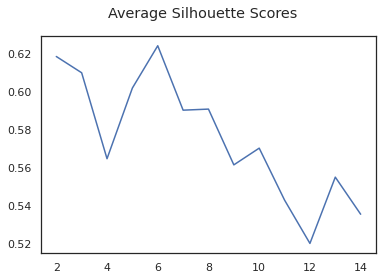

In [8]:
# preparing for sillouette analysis.
x = []
y = []

for k in range(2,15):
    
    # using mlg table, we will conduct sillouette analysis to see where the listings are clustered.
    kmeans = KMeans(n_clusters=k, n_init=25, random_state=42).fit(data)
    
    # calculate the overall silhouette score here.
    silhouette_avg = silhouette_score(data, kmeans.labels_)
    
    y.append(k)
    x.append(silhouette_avg)
    
    print('.', end='')

print()
print(f"Largest silhouette score was {max(x):6.4f} for k={y[x.index(max(x))]}")

plt.plot(y, x)
plt.gcf().suptitle("Average Silhouette Scores")

In [9]:
# number of clusters
k_pref=6

# calcaulting the clustering based on the mlg table.
kmeans = KMeans(n_clusters=k_pref, n_init=25, random_state=42).fit(data)
    
# calculating the overall silhouette score
silhouette_avg = silhouette_score(data, kmeans.labels_)

# Calculating the silhouette values
sample_silhouette_values = silhouette_samples(data, kmeans.labels_)
    
# creating a subplot with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(9, 5)

# the 1st subplot is the silhouette plot
# the silhouette coefficient can range from -1, 1
ax1.set_xlim([-1.0, 1.0])
    
# the (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, data.shape[0] + (k + 1) * 10])
    
y_lower = 10
    
# for each of the clusters...
for i in range(k_pref):
    # aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = \
        sample_silhouette_values[kmeans.labels_ == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
        
    # set the color ramp
    color = plt.cm.Spectral(i/k)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                        0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=0.7)

    # label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # the vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--", linewidth=0.5)

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks(np.arange(-1.0, 1.1, 0.2)) # Was: [-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1]

    # 2nd Plot showing the actual clusters formed --
    # we can only do this for the first two dimensions
    # so we may not see fully what is causing the 
    # resulting assignment
    colors = plt.cm.Spectral(kmeans.labels_.astype(float) / k)
    ax2.scatter(data[data.columns[0]], data[data.columns[1]], 
                marker='.', s=30, lw=0, alpha=0.7, c=colors)

    # labeling the clusters
    centers = kmeans.cluster_centers_
    
    # draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("Visualization of the clustered data")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

plt.suptitle(("Silhouette results for KMeans clustering "
                "with %d clusters" % k_pref),
                fontsize=14, fontweight='bold')
plt.show()